In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV

In [2]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
PROCESSED_DATA =  os.path.join(ROOT_FOLDER, "data","processed")

In [3]:
ICU_TAB_FEATURES = os.path.join(PROCESSED_DATA,"icu_tabular_features_0M_0ed859c799267d4ae737f8814d52726d_20240518.feather")
ICU_STAYS = os.path.join(PROCESSED_DATA,"icustays_20240602.feather")

In [4]:
df1 = feather.read_feather(ICU_STAYS )
df1.head()

,subject_id,hadm_id,icu_stay_id,first_careunit,icu_intime,icu_outtime,icu_los,hours_until_readmission,will_be_readmitted,hours_to_readmission,stay_is_readmission
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,NaN,False,NaN,False
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,NaN,False,NaN,False
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,665.573333,True,NaN,False
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,NaN,False,665.573333,True
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,NaN,False,NaN,False


In [5]:
df2 = feather.read_feather(ICU_TAB_FEATURES)
df2.head()

,hadm_id,subject_id,stay_id,Arterial Blood Pressure diastolic_max,Arterial Blood Pressure diastolic_mean,Arterial Blood Pressure diastolic_min,Arterial Blood Pressure diastolic_std,Arterial Blood Pressure mean_max,Arterial Blood Pressure mean_mean,Arterial Blood Pressure mean_min,...,pO2_median,pO2_min,pO2_std,urine_last_1d,anchor_age,is_planed,is_surg,aids,neoplasie,metastatic_cancer
0,23786647,10018328,31269608,58.0,53.818182,49.0,3.250175,89.0,81.909091,75.0,...,NaN,NaN,NaN,2130.0,83,False,True,None,None,None
1,24104168,10020187,37509585,75.0,62.888889,47.0,7.653441,103.0,85.222222,63.0,...,NaN,NaN,NaN,3380.0,63,False,True,None,None,None
2,26842957,10020187,32554129,74.0,58.250000,49.0,7.827303,101.0,80.062500,66.0,...,NaN,NaN,NaN,2150.0,63,False,True,None,None,None
3,27882036,10012853,31338022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.5,51.0,2.12132,1375.0,91,False,False,None,None,None
4,25826145,10020740,32145159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2240.0,56,False,True,None,None,None


In [6]:
merged_df = pd.merge(df1, df2, on='subject_id')
merged_df.head()

,subject_id,hadm_id_x,icu_stay_id,first_careunit,icu_intime,icu_outtime,icu_los,hours_until_readmission,will_be_readmitted,hours_to_readmission,...,pO2_median,pO2_min,pO2_std,urine_last_1d,anchor_age,is_planed,is_surg,aids,neoplasie,metastatic_cancer
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,NaN,False,NaN,...,NaN,NaN,NaN,175.0,52,False,False,None,None,None
1,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,665.573333,True,NaN,...,NaN,NaN,NaN,2645.0,55,False,True,None,None,None
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,665.573333,True,NaN,...,NaN,NaN,NaN,2475.0,55,False,True,None,None,None
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,NaN,False,665.573333,...,NaN,NaN,NaN,2645.0,55,False,True,None,None,None
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,NaN,False,665.573333,...,NaN,NaN,NaN,2475.0,55,False,True,None,None,None


In [7]:
# Find duplicates based on 'subject_id' and 'icu_stay_id', 'icu_intime' , 'icu_outtime'
duplicates = merged_df[merged_df.duplicated(subset=['subject_id', 'icu_stay_id','icu_intime','icu_outtime'], keep=False)]
#print(duplicates)

In [8]:
# Remove duplicates, keeping the first occurrence
merged_df = merged_df.drop_duplicates(subset=['subject_id', 'icu_stay_id', 'icu_intime','icu_outtime'], keep='first')
merged_df.head()

,subject_id,hadm_id_x,icu_stay_id,first_careunit,icu_intime,icu_outtime,icu_los,hours_until_readmission,will_be_readmitted,hours_to_readmission,...,pO2_median,pO2_min,pO2_std,urine_last_1d,anchor_age,is_planed,is_surg,aids,neoplasie,metastatic_cancer
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,NaN,False,NaN,...,NaN,NaN,NaN,175.0,52,False,False,None,None,None
1,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,665.573333,True,NaN,...,NaN,NaN,NaN,2645.0,55,False,True,None,None,None
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,NaN,False,665.573333,...,NaN,NaN,NaN,2645.0,55,False,True,None,None,None
5,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,NaN,False,NaN,...,NaN,NaN,NaN,1965.0,46,False,False,None,None,None
6,10002428,20321825,34807493,Medical Intensive Care Unit (MICU),2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,208.370556,True,98.905278,...,65.0,40.0,37.729299,888.0,80,False,False,None,None,None


In [9]:
# Create 'readmitted' column based on 'hours_until_readmission'
merged_df['readmitted'] = merged_df['hours_until_readmission'].apply(lambda x: 1 if x <= 720 else 0)
merged_df['readmitted'] = merged_df['readmitted'].fillna(0).astype(int)
print(merged_df[['subject_id','icu_stay_id','hours_until_readmission', 'readmitted']].head(10))

    subject_id icu_stay_id  hours_until_readmission  readmitted
0     10000032    39553978                      NaN           0
1     10001217    37067082               665.573333           1
3     10001217    34592300                      NaN           0
5     10001725    31205490                      NaN           0
6     10002428    34807493               208.370556           1
10    10002428    35479615                      NaN           0
14    10002428    33987268                50.236389           1
18    10002428    38875437                98.905278           1
22    10002495    36753294                      NaN           0
23    10002930    37049133                      NaN           0


In [10]:
nan_columns = merged_df.isnull().sum()
nan_columns = nan_columns[nan_columns > 0]
#print("Columns with NaN values and their counts:\n", nan_columns)

In [11]:
# Calculate the percentage of NaN values for each column
nan_percentage = merged_df.isnull().mean()

# Set a threshold, for example, 90%
threshold = 0.90

# Identify columns to drop
columns_to_drop = nan_percentage[nan_percentage > threshold].index

# Drop these columns from the dataset
merged_df_cleaned = merged_df.drop(columns=columns_to_drop)

# Display the columns that were removed
removed_columns = columns_to_drop.tolist()
#print("Removed columns:", removed_columns)

In [12]:
nan_columns = merged_df_cleaned.isnull().sum()
nan_columns = nan_columns[nan_columns > 0]
#print("Columns with NaN values and their counts:\n", nan_columns)

In [13]:
# Fill missing values with the mean or "unknown" value
for column in nan_columns.index:
    if merged_df_cleaned[column].dtype == 'float64' or merged_df_cleaned[column].dtype == 'int64':
        # Fill numerical columns with the mean
        merged_df_cleaned[column] = merged_df_cleaned[column].fillna(merged_df_cleaned[column].mean())
    else:
        # Fill categorical columns with "unknown" value
        merged_df_cleaned[column] = merged_df_cleaned[column].fillna('unknown')

# Check for missing values after filling
nan_columns_after = merged_df_cleaned.isnull().sum()
nan_columns_after = nan_columns_after[nan_columns_after > 0]
print("Columns with NaN values after filling:\n", nan_columns_after)

Columns with NaN values after filling:
 Series([], dtype: int64)


In [14]:
# Separate numeric and non-numeric columns
numeric_columns = merged_df_cleaned.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = merged_df_cleaned.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values for numeric columns with the mean
merged_df_cleaned[numeric_columns] = merged_df_cleaned[numeric_columns].fillna(merged_df_cleaned[numeric_columns].mean())

# For categorical columns, first add 'unknown' as a category and then fill NaNs
for column in non_numeric_columns:
    if merged_df_cleaned[column].dtype.name == 'category':
        merged_df_cleaned[column] = merged_df_cleaned[column].cat.add_categories('unknown')
    merged_df_cleaned[column] = merged_df_cleaned[column].fillna('unknown')

# Check again for any remaining missing values
nan_columns_after = merged_df_cleaned.isnull().sum()
nan_columns_after = nan_columns_after[nan_columns_after > 0]
print("Columns with NaN values after filling:\n", nan_columns_after)
#print(merged_df_cleaned.shape)

Columns with NaN values after filling:
 Series([], dtype: int64)


Top features based on combined methods:
0                                    icu_los
250                              Glucose_max
262                           Hematocrit_max
130                    Respiratory Rate_mean
242                           Creatinine_max
348                               Sodium_min
374                            urine_last_1d
319                    Platelet Count_median
251                           Glucose_median
190                       Strength L Leg_max
318                       Platelet Count_max
299                         Magnesium_median
298                            Magnesium_max
320                       Platelet Count_min
289                                 MCHC_std
198                       Strength R Leg_max
243                        Creatinine_median
328                            Potassium_min
252                              Glucose_min
210                            Anion Gap_max
132                     Respiratory Rate_std
358            

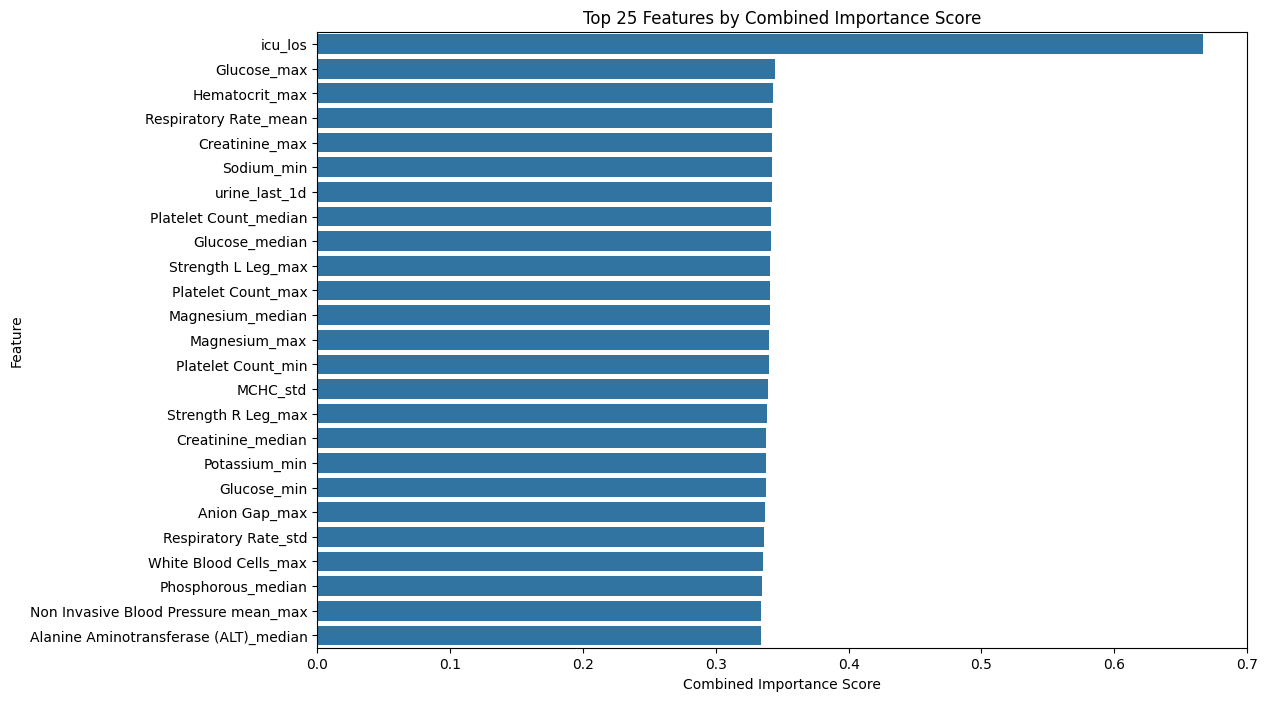

In [15]:
# Define features and target variable
X = merged_df_cleaned.drop(['readmitted', 'hours_until_readmission', 'hours_to_readmission', 'subject_id', 'stay_id' , 'hadm_id_x', 'hadm_id_y'], axis=1)
y = merged_df_cleaned['readmitted']

# Select only numeric columns for model training
numeric_X = X.select_dtypes(include=['float64', 'int64'])

# RandomForest Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(numeric_X, y)
rf_importances = rf_model.feature_importances_

# RFE
rfe = RFE(estimator=rf_model, n_features_to_select=25, step=1)
rfe.fit(numeric_X, y)
rfe_ranking = rfe.ranking_

# Logistic Regression with L1 penalty
log_reg = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', random_state=42)
log_reg.fit(numeric_X, y)
log_reg_coef = np.abs(log_reg.coef_[0])  # Taking absolute to get magnitude

# Create a DataFrame for all feature scores
features = numeric_X.columns
scores_df = pd.DataFrame({
    'Feature': features,
    'RandomForest': rf_importances,
    'RFE': 1 / rfe_ranking,  # Inverse ranking, lower rank gets higher importance
    'Logistic_L1': log_reg_coef
})

# Normalize the scores
scores_df['RandomForest'] = scores_df['RandomForest'] / scores_df['RandomForest'].max()
scores_df['RFE'] = scores_df['RFE'] / scores_df['RFE'].max()
scores_df['Logistic_L1'] = scores_df['Logistic_L1'] / scores_df['Logistic_L1'].max()

# Aggregate the normalized scores
scores_df['CombinedScore'] = scores_df[['RandomForest', 'RFE', 'Logistic_L1']].mean(axis=1)

# Sort by the combined score
scores_df = scores_df.sort_values(by='CombinedScore', ascending=False)

# Select top features
top_features_combined = scores_df.head(25)['Feature']

print("Top features based on combined methods:")
print(top_features_combined)

# Plotting the combined feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='CombinedScore', y='Feature', data=scores_df.head(25))
plt.title('Top 25 Features by Combined Importance Score')
plt.xlabel('Combined Importance Score')
plt.ylabel('Feature')
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.50      0.33      0.40         3

    accuracy                           0.89        27
   macro avg       0.71      0.65      0.67        27
weighted avg       0.87      0.89      0.88        27

[[23  1]
 [ 2  1]]
ROC AUC Score: 0.7777777777777778


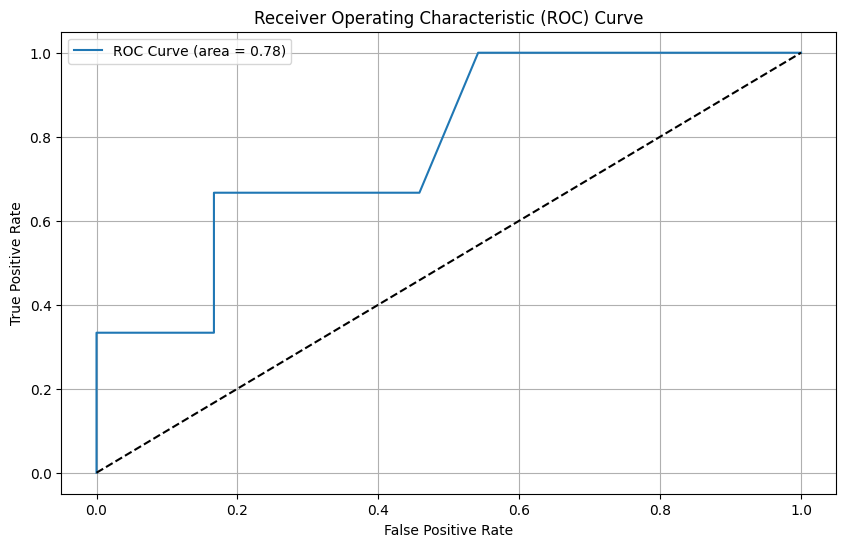

In [16]:
# Define the important features
important_features = [
    "icu_los",
    "Glucose_max",
    "Hematocrit_max",
    "Respiratory Rate_mean",
    "Creatinine_max",
    "Sodium_min",
    "urine_last_1d",
    "Platelet Count_median",
    "Glucose_median",
    "Strength L Leg_max",
    "Platelet Count_max",
    "Magnesium_median",
    "Magnesium_max",
    "Platelet Count_min",
    "MCHC_std",
    "Strength R Leg_max",
    "Creatinine_median",
    "Potassium_min",
    "Glucose_min",
    "Anion Gap_max",
    "Respiratory Rate_std",
    "White Blood Cells_max",
    "Phosphorous_median",
    "Non Invasive Blood Pressure mean_max",
    "Alanine Aminotransferase (ALT)_median"
]


# Filter the dataset to only include these important features
X_important_features = merged_df_cleaned[important_features]

# Define target variable
y = merged_df_cleaned['readmitted']

# Handle any remaining missing values by filling with mean (or appropriate method)
X_important_features = X_important_features.fillna(X_important_features.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Get feature importances
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X_important_features.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        25
           1       1.00      0.80      0.89        20

    accuracy                           0.91        45
   macro avg       0.93      0.90      0.91        45
weighted avg       0.92      0.91      0.91        45

[[25  0]
 [ 4 16]]
ROC AUC Score: 0.9480000000000001


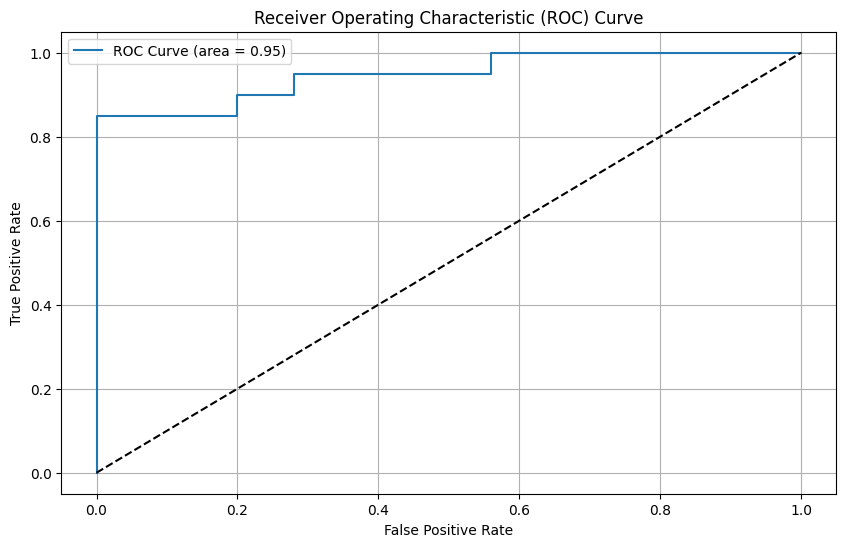

In [17]:
# Filter the dataset to only include these important features
X_important_features = merged_df_cleaned[important_features]

# Define target variable
y = merged_df_cleaned['readmitted']

# Handle any remaining missing values by filling with mean (or appropriate method)
X_important_features = X_important_features.fillna(X_important_features.mean())

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_important_features, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Get feature importances
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X_important_features.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
#plt.figure(figsize=(12, 8))
#sns.barplot(x='Importance', y='Feature', data=features_df)
#plt.title('Feature Importances')
#plt.show()

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


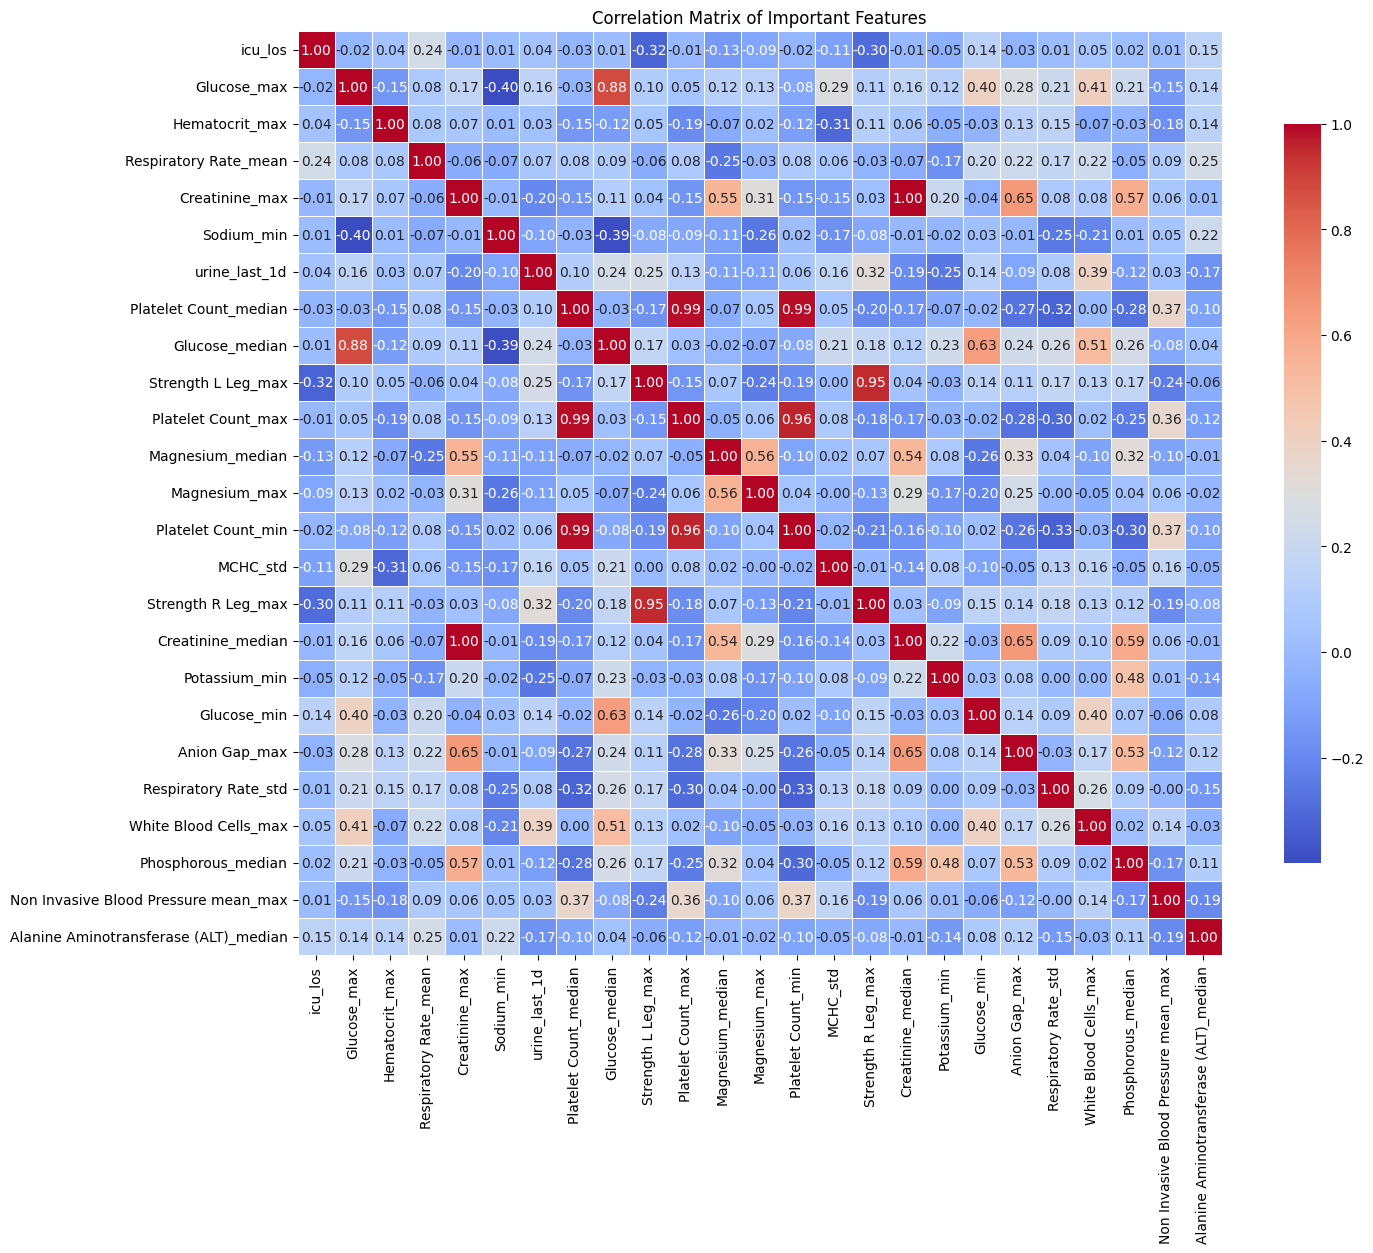

In [18]:
# Filter the dataset to only include these important features
X_important_features = merged_df_cleaned[important_features]

# Calculate the correlation matrix
correlation_matrix = X_important_features.corr()

#Set the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add title
plt.title('Correlation Matrix of Important Features')

# Show plot
plt.show()

In [19]:
# Define threshold
threshold = 0.90 

# Create an empty set to keep track of indices of the columns to drop
to_drop = set()

# Iterate over the upper triangle of the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Add the column index j to the set of columns to drop
            to_drop.add(correlation_matrix.columns[j])

# Convert set to list to handle next operations
to_drop = list(to_drop)
# Drop highly correlated features
X_filtered = X_important_features.drop(columns=to_drop)
print("Dropped columns:", to_drop)
print("Remaining features:", X_filtered.columns)

Dropped columns: ['Creatinine_median', 'Platelet Count_min', 'Platelet Count_max', 'Strength R Leg_max']
Remaining features: Index(['icu_los', 'Glucose_max', 'Hematocrit_max', 'Respiratory Rate_mean',
       'Creatinine_max', 'Sodium_min', 'urine_last_1d',
       'Platelet Count_median', 'Glucose_median', 'Strength L Leg_max',
       'Magnesium_median', 'Magnesium_max', 'MCHC_std', 'Potassium_min',
       'Glucose_min', 'Anion Gap_max', 'Respiratory Rate_std',
       'White Blood Cells_max', 'Phosphorous_median',
       'Non Invasive Blood Pressure mean_max',
       'Alanine Aminotransferase (ALT)_median'],
      dtype='object')


              precision    recall  f1-score   support

           0       0.86      1.00      0.93        25
           1       1.00      0.80      0.89        20

    accuracy                           0.91        45
   macro avg       0.93      0.90      0.91        45
weighted avg       0.92      0.91      0.91        45

[[25  0]
 [ 4 16]]
ROC AUC Score: 0.9460000000000001


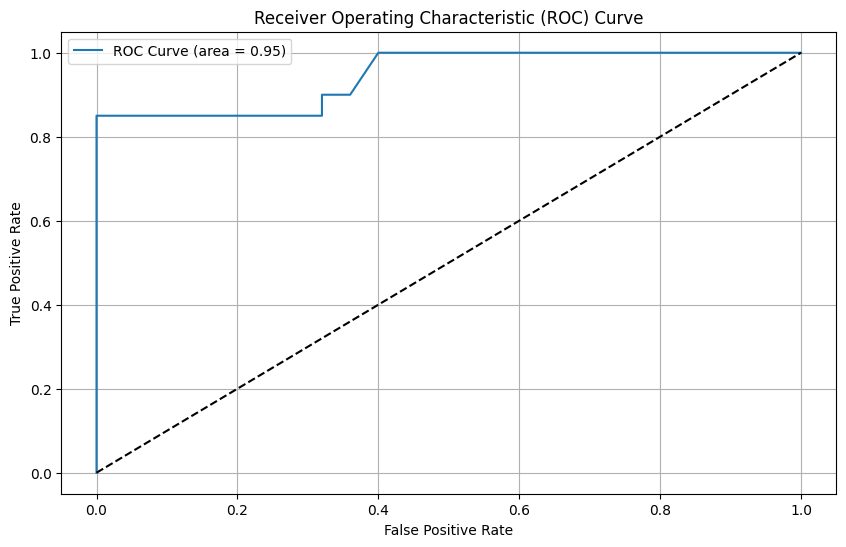

In [20]:
# Update the important features list
important_features = ['icu_los', 'Glucose_max', 'Hematocrit_max', 'Respiratory Rate_mean',
       'Creatinine_max', 'Sodium_min', 'urine_last_1d',
       'Platelet Count_median', 'Glucose_median', 'Strength L Leg_max',
       'Magnesium_median', 'Magnesium_max', 'MCHC_std', 'Potassium_min',
       'Glucose_min', 'Anion Gap_max', 'Respiratory Rate_std',
       'White Blood Cells_max', 'Phosphorous_median',
       'Non Invasive Blood Pressure mean_max',
       'Alanine Aminotransferase (ALT)_median']

# Filter the dataset to only include these important features
X_important_features = merged_df_cleaned[important_features]

# Define target variable
y = merged_df_cleaned['readmitted']

# Handle any remaining missing values by filling with mean (or appropriate method)
X_important_features = X_important_features.fillna(X_important_features.mean())

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_important_features, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Get feature importances
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X_important_features.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Optionally uncomment to plot feature importances
#plt.figure(figsize=(12, 8))
#sns.barplot(x='Importance', y='Feature', data=features_df)
#plt.title('Feature Importances')
#plt.show()

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

In [22]:
import pickle

# Save the model
model_path = '/workspaces/xitaso/models/Readmission_Model.pkl'  # Save as model.pkl in the models directory
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f'Model successfully saved: {model_path}')

Model successfully saved: /workspaces/xitaso/models/Readmission_Model.pkl
